# 이미지 데이터 소개

컴퓨터 비전 분야의 경우 일반적으로 다음의 문제들을 해결하고자 합니다.

* **Image Classification** : 이미지를 사전에 정의된 여러 범주 중 하나로 분류해야 하는 문제입니다. 예를 들어 사진에서 고양이와 개를 구별하거나, 손으로 쓴 숫자를 인식할 수 있습니다.

* **Object Detection** : 사진에서 알려진 객체를 찾아 판별하는 좀 더 어려운 문제입니다. 즉, 인식된 각 객체에 대해 **경계 상자(bounding box)** 를 출력해야 합니다.

* **Segmentation** : Object Detection과 유사하지만 경계 상자를 제공하는 대신 인식된 각 물체의 윤곽을 그리는 정확한 픽셀 맵을 출력해야 합니다.

![An image showing how computer vision object detection can be performed with cats, dogs, and ducks.](https://i.stack.imgur.com/mFBCV.png)

이미지 출처 : [CS224d Stanford Course](https://cs224d.stanford.edu/index.html)

## 텐서로서의 이미지

Computer Vision은 이미지와 함께 작동합니다. 이때 이미지는 픽셀로 구성되어 있으므로 픽셀의 직사각형 모음(Array)으로 생각할 수 있습니다.

이 튜토리얼의 첫 번째 부분에서는 손으로 쓴 숫자 인식을 다룰 것이며, 이를 위해 손으로 쓴 숫자의 흑백 이미지, 28x28 픽셀로 구성된 MNIST 데이터셋을 사용합니다. 각 이미지는 28x28 Array로 표현 될 수 있으며 이 Array의 요소는 0부터 1 (부동 소수점 숫자가 사용되는 경우) 또는 0에서 255 (정수) 범위의 스케일로 해당 픽셀의 강도를 나타냅니다. Python 라이브러리 중 하나인 `numpy`는 다차원 Array에 대해 효과적으로 작동할 수 있기 때문에 컴퓨터 비전 작업에 자주 사용됩니다.

컬러 이미지를 다루려면 색상을 표현하는 방법이 필요합니다. 대부분의 경우 빨간색 (R), 녹색 (G) 및 파란색 (B) 구성 요소에 해당하는 3 개의 픽셀 강도 값으로 각 픽셀을 나타냅니다. 이 색상 인코딩을 RGB라고 하므로 $ W \times H $ 크기의 색상 이미지는 $ 3 \times H \times W $ 크기의 배열로 표시됩니다 (때로는 구성 요소의 순서가 다를 수 있지만 아이디어는 동일합니다).

다차원 배열은 **Tensor**라고도 합니다. 이미지를 표현하기 위해 Tensor를 사용할 경우 추가 차원을 사용하여 이미지 시퀀스를 저장할 수 있다는 장점이 있습니다. 예를 들어 800x600 크기의 200개 프레임으로 구성된 비디오 조각을 나타 내기 위해 200x3x600x800 크기의 Tensor를 사용할 수 있습니다.

## 패키지 임포트와 MNIST 데이터셋 로드


In [6]:
#Import the packages needed.
import torch
import torchvision
import matplotlib.pyplot as plt
import numpy as np

PyTorch에는 라이브러리에서 바로 사용할 수 있는 [datasets](https://pytorch.org/vision/stable/datasets.html)가 있습니다. 아래 예제에서는 PyTorch의 `torchvison.datasets.MNIST`를 통해 사용할 수 있는 손글씨 이미지 [MNIST](http://yann.lecun.com/exdb/mnist/)를 사용합니다. 데이터셋 객체는 `transform=ToTensor()` 파라미터를 통해 전달하며, Tensor로 변환하는 PIL(Python Imagine Library) 이미지 형식의 데이터를 반환합니다.

필요에 따라 다른 데이터셋, 특히 [FashionMNIST](https://pytorch.org/vision/stable/datasets.html#fashion-mnist)를 이용하여 학습을 진행할 수도 있습니다.

In [7]:
from torchvision.transforms import ToTensor

data_train = torchvision.datasets.MNIST('./data',
        download=True,train=True,transform=ToTensor())
data_test = torchvision.datasets.MNIST('./data',
        download=True,train=False,transform=ToTensor())

## 숫자 데이터셋 시각화

데이터셋을 다운로드 하였으므로 일부 이미지를 시각화할 수 있습니다.

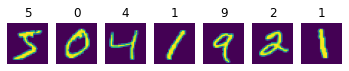

In [8]:
fig,ax = plt.subplots(1,7)
for i in range(7):
    ax[i].imshow(data_train[i][0].view(28,28))
    ax[i].set_title(data_train[i][1])
    ax[i].axis('off')

## 데이터셋 구조

총 6,000개의 훈련 이미지와 1,000개의 평가 이미지가 있습니다. 훈련 및 평가를 위해 데이터를 분할하는 것이 중요합니다. 또한 데이터가 어떻게 생겼는지 더 잘 파악하기 위해 데이터 탐색을 진행하려고 합니다.

각 샘플은 다음 구조를 가진 튜플(tuple)입니다.
 * 첫 번째 요소는 1x28x28 크기의 Tensor입니다.
 * 두 번째 요소는 Tensor가 나타내는 숫자를 지정하는 레이블입니다.

In [9]:
print('Training samples:',len(data_train))
print('Test samples:',len(data_test))

print('Tensor size:',data_train[0][0].size())
print('First 10 digits are:', [data_train[i][1] for i in range(10)])

Training samples: 60000
Test samples: 10000
Tensor size: torch.Size([1, 28, 28])
First 10 digits are: [5, 0, 4, 1, 9, 2, 1, 3, 1, 4]


이미지의 모든 픽셀 강도는 0과 1 사이의 부동 소수점 값으로 표시됩니다.

In [10]:
print('Min intensity value: ',data_train[0][0].min().item())
print('Max intensity value: ',data_train[0][0].max().item())

Min intensity value:  0.0
Max intensity value:  1.0


자신만의 이미지를 불러오려는 경우 신경망 훈련을 시작하기 전에 모든 값이 [**0 - 1**] 범위로 조정되었는지 확인하는 것이 중요합니다.

이제 훈련 및 평가 데이터셋을 불러왔으며 첫 번째 신경망 훈련을 시작할 준비가 되었습니다!